# Introduction

In this tutorial, we will explore a modelling framework that refines the **traditional degree-day approach** for describing larval development in relation to temperature. This framework is implemented in the [**Population package**](https://kerguler.github.io/Population/) and the companion [**PopJSON language**](https://kerguler.github.io/PopJSON/), designed to make population modelling more transparent, flexible, and reproducible. 

The approach is also described in recent publications [Erguler et al. 2018, *F1000Research*](https://doi.org/10.12688/f1000research.15824.3) and [Erguler et al. 2022, *Scientific Reports*](https://doi.org/10.1038/s41598-022-15806-2).

### From Degree-Days to Data-Driven Development

Traditionally, growth is calculated by how many **degree-days** an organism accumulates above a baseline temperature. 

For example:
- If larvae require at least 10 °C to grow, then spending one day at 11 °C counts as one degree-day.  
- A day at 12 °C counts as two degree-days, and so on.  

Instead of assuming a perfectly linear relationship between temperature and development, we allow for a complex dependencies, **species-specific, non-linear functions**, informed by **experimental data**. For instance,

- If larvae take 20 days to complete development at 20 °C, we assume they accumulate 1/20 of their development each day.  
- At 30 °C, if development takes 5 days, then accumulation proceeds at 1/5 per day.

Our model relaxes the idea of a **fixed heat accumulation threshold**.  

- Instead of requiring, for example, exactly 3,000 degree-days for development, we treat development time as a **distribution**.  
- A population might develop around 30 days with some variability.  
- This variability can be described using an **Erlang distribution** or other probabilistic approaches.  

Finally, our model incorporates **multiple time-dependent processes** acting on a population. We assume that each process realises in sequence and dynamically structures the population into a set of pseudo-stages, each with a specific time distribution.

This tutorial will guide you through building such models step by step, using [Population](https://kerguler.github.io/Population/) and [PopJSON](https://kerguler.github.io/PopJSON/) to put these concepts into practice.

In [ ]:
# This is a wrapper that comes with the PopJSON library (written in NodeJS)
# It exists in $POPJSON_WPATH or node_modules/popjson/wrappers/
# Here, it is symbolically linked to the working directory.
#
sys.call("cp $POPJSON_WPATH/population.* ./")
#
source("population.R")

In [3]:
# This is a convenience script to parse PopJSON models into C (which implements the Population model)
# and compile as a "dylib" for access from R
# 
prepare <- function(filename) {
    out <- system(sprintf("node compile.js %s", filename), intern = TRUE)
    print(out)
    #
    if (exists("model") && inherits(model, "PopulationModel")) model$destroy()
    #
    model <- PopulationModel$new(sprintf("%s.dylib", filename))
    #
    return(model)
}

### Let's use models/example.json to represent larval growth dynamics.

Please refer to [**Population package**](https://kerguler.github.io/Population/) and [**PopJSON language**](https://kerguler.github.io/PopJSON/) for descriptions of what's possible.

In [ ]:
model <- prepare("models/example")

[1] "Reading model file: models/example.json" 
[2] "Model translated to models/example.c"    
[3] "Model file created: models/example.dylib"


Loaded model with: 1 pops, 0 pars, 0 ints, 0 envs.



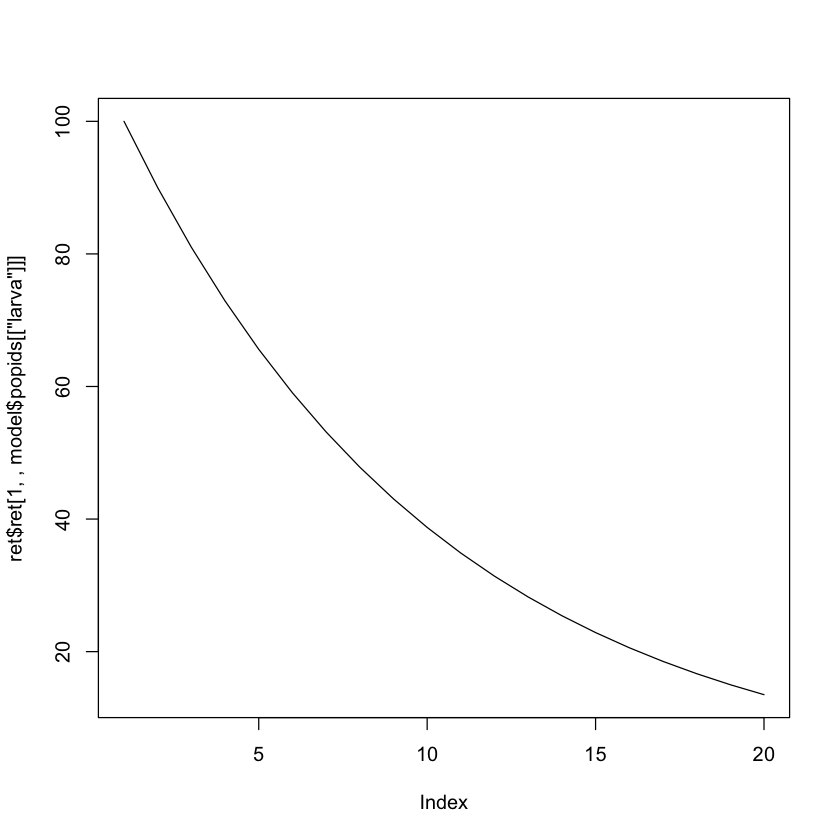

In [13]:
ret <- model$sim(ftime = 20, 
                 y0 = list(larva = 100.0))

plot(ret$ret[1, , model$popids[["larva"]]], t = "l")

# Semi-field experiments

Let's try investigating something more complex but realistic. In 2022, we published an analysis using the  set of semi-field experiments on immature stage development of *Culex pipiens* biotype *molestus*, performed by Dusan Petric's group. Please refer to [Erguler et al. 2022, *Scientific Reports*](https://doi.org/10.1038/s41598-022-15806-2) for more information.

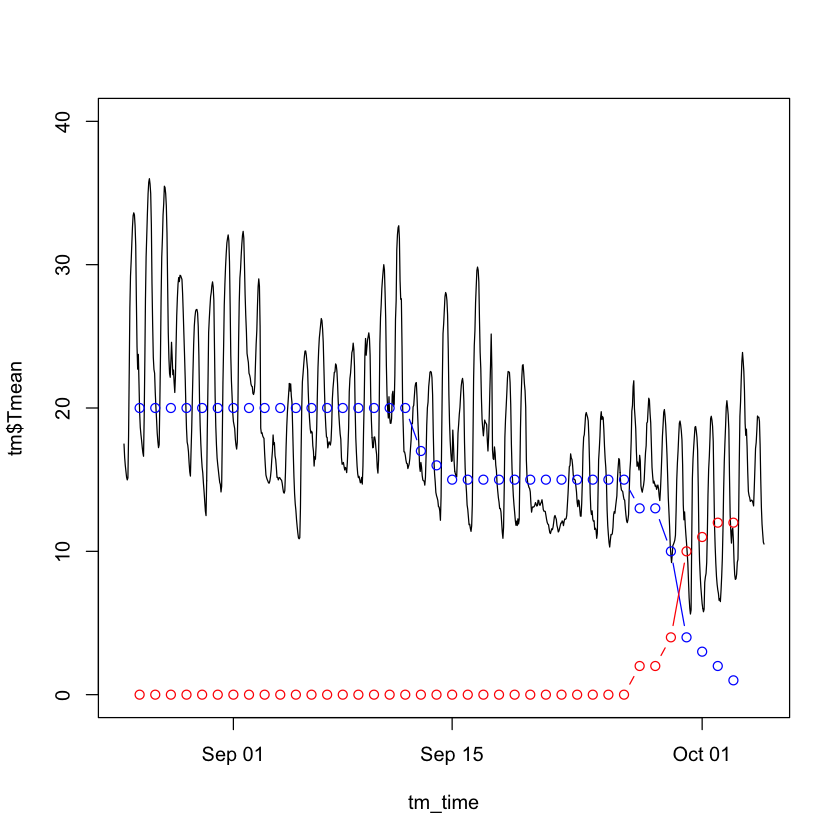

In [67]:
df <- read.csv("data/data_semifield.csv")
df_time <- as.POSIXct(df$Date, format="%d/%m/%Y")

tm <- read.csv("data/datalogger.csv")
tm_time <- as.POSIXct(tm$Time, format="%Y-%m-%d %H:%M:%S")

plot(tm_time,tm$Tmean,t='l',ylim=c(0,40))
lines(df_time,df$L,t='b',col='blue')
lines(df_time,df$P,t='b',col='red')

We propose an equation to link temperature to larva development and survival. The double sigmoidal is my favourite for its flexibility and ease of interpretation.

In [ ]:
dsig <-function(T,L,l,R,r,M,X) {
    return (((M) + ((X) / ((1.0 + exp(exp((l)) * ((L) - (T)))) * (1.0 + exp(exp((r)) * ((T) - ((L) + (R)))))))))
}

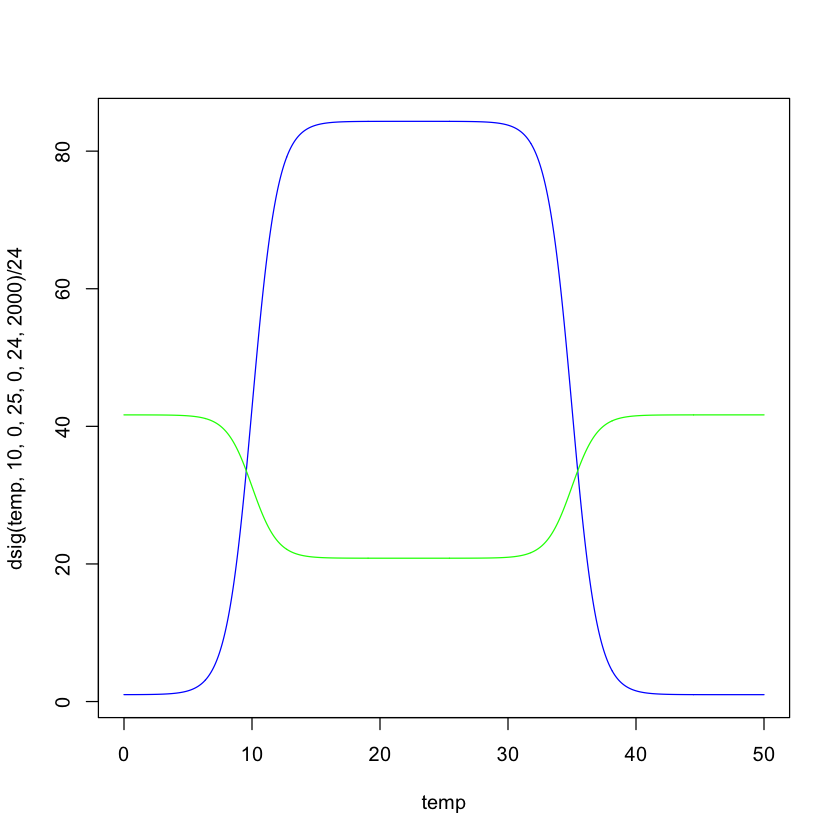

In [6]:
temp <- seq(0, 50, length.out = 1000)

plot(temp, dsig(temp,10,0,25,0,24,2000) / 24, t='l', col='blue')
lines(temp, dsig(temp,10,0,25,0,1000,-500) / 24, t='l', col='green')

Let's go over the rest one step at a time, together...

In [56]:
model <- prepare("models/model_larva")

[1] "Reading model file: models/model_larva.json" 
[2] "Model translated to models/model_larva.c"    
[3] "Model file created: models/model_larva.dylib"


Loaded model with: 1 pops, 12 pars, 4 ints, 1 envs.



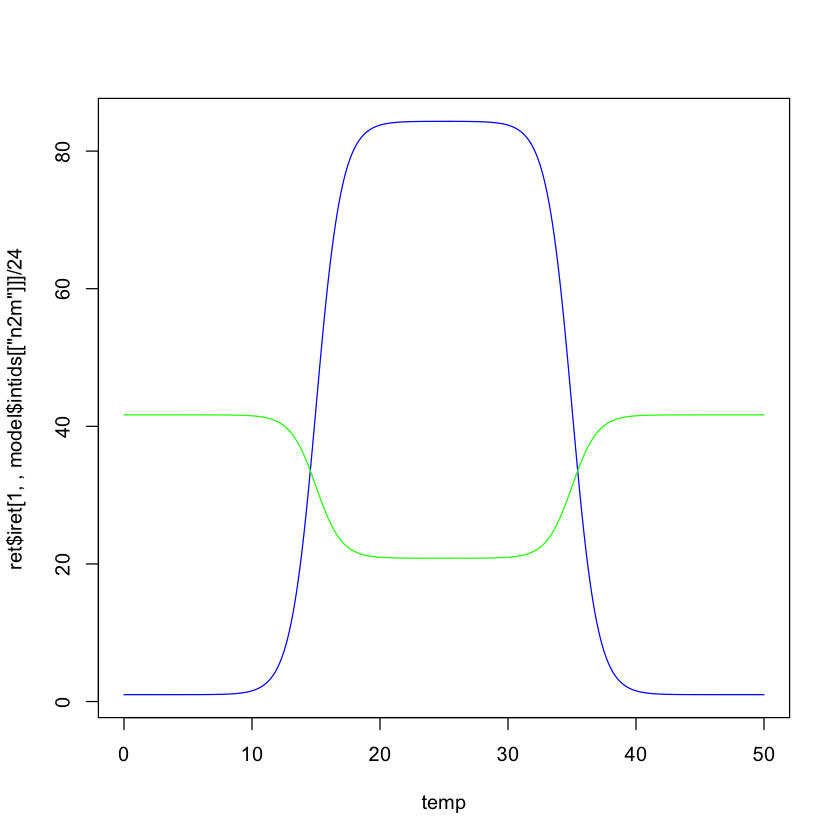

In [57]:
temp <- seq(0,50,length.out=1000)

param <- model$param

ret <- model$sim(
  ftime = length(temp)+1,
  envir = list(
    temp = temp
  ),
  pr = param,
  rep = -1
)

plot(temp, ret$iret[1, , model$intids[["n2m"]]] / 24.0, t='l', col='blue')
lines(temp, ret$iret[1, , model$intids[["d2m"]]] / 24.0, t='l', col='green')

In [58]:
temp <- tm$Tmean

param <- model$param

ret <- model$sim(
  ftime = length(temp),
  envir = list(
    temp = temp
  ),
  pr = param,
  y0 = list(
    larva = 20.0
  )
)

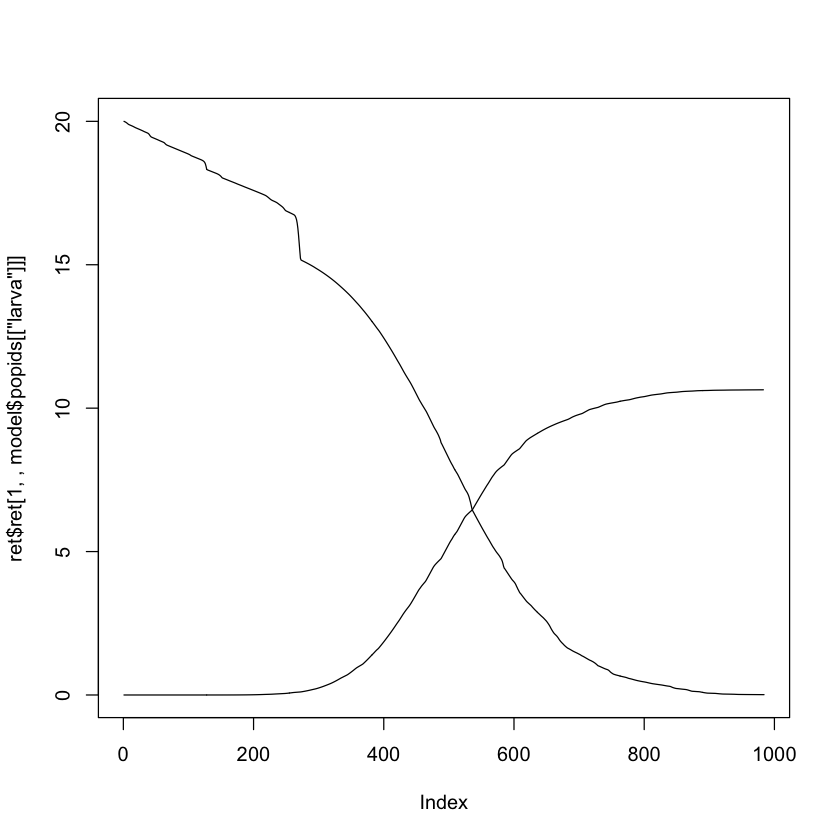

In [59]:
plot(ret$ret[1, , model$popids[["larva"]]], t = "l")
lines(cumsum(ret$iret[1, , model$intids[["larva_to_pupa"]]]), t = "l")

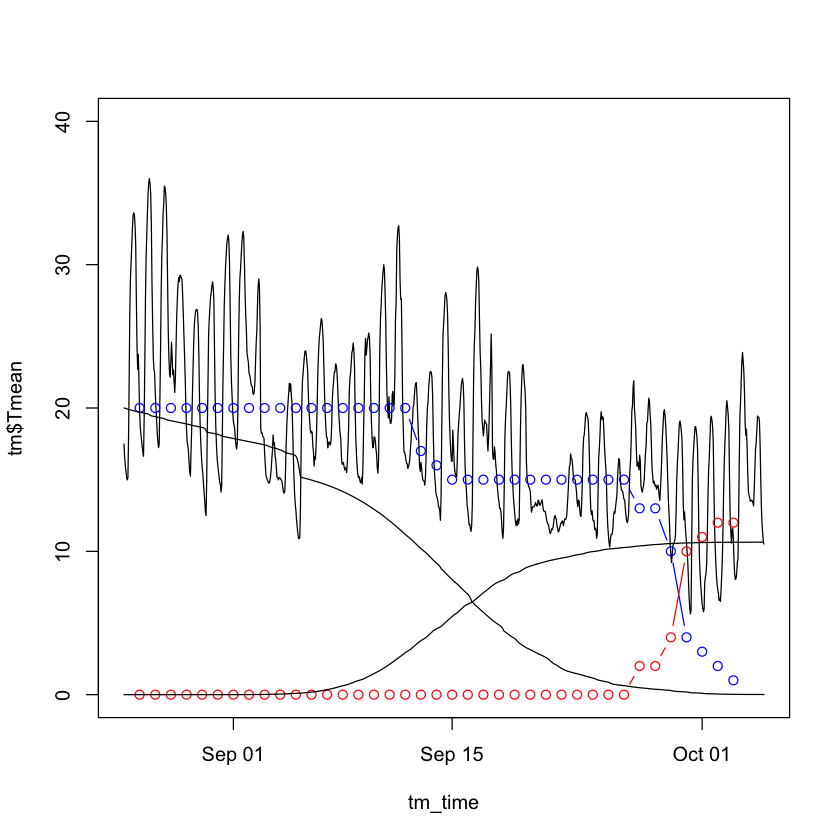

In [60]:
plot(tm_time,tm$Tmean,t='l',ylim=c(0,40))
lines(df_time,df$L,t='b',col='blue')
lines(df_time,df$P,t='b',col='red')
lines(tm_time,ret$ret[1, , model$popids[["larva"]]], t = "l")
lines(tm_time[-length(tm_time)],cumsum(ret$iret[1, , model$intids[["larva_to_pupa"]]]), t = "l")

In [61]:
obs <- df
obs['hour'] <- (1:nrow(obs))*12

simulate_system <- function(param) {
  temp <- tm$Tmean
  hours <- length(temp)

  ret <- model$sim(
    ftime = hours,
    envir = list(
      temp = temp
    ),
    pr = param,
    y0 = list(
      larva = 20.0
    )
  )

  return(data.frame(hour = (1:hours)-1, 
                    larva = ret$ret[1, , model$popids[["larva"]]],
                    pupa = c(cumsum(ret$iret[1, , model$intids[["larva_to_pupa"]]]), NA)))
}

objective_function <- function(param) {
  sim <- simulate_system(param)
  # Extract simulation only at obs times
  sim_at_obs <- sim[tm_time %in% df_time, ]
  # sum of squared errors (larva + pupa)
  SSE <- sum((obs$L - sim_at_obs$larva)^2 + (obs$P - sim_at_obs$pupa)^2)
  return(SSE)
}

In [62]:
objective_function(param)

[1] 3722.04

In [63]:
lower_bounds <- model$parmin
upper_bounds <- model$parmax

fit <- optim(
  par = model$param,
  fn = objective_function,
  method = "L-BFGS-B",
  lower = lower_bounds,
  upper = upper_bounds
)

print(fit)

$par
 [1]    9.892222    5.983674   50.000000    6.000000   14.029705 4550.024496
 [7]   50.000000    6.000000  -10.000000   -6.000000  465.430554  946.066874

$value
[1] 232.7981

$counts
function gradient 
     137      137 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"



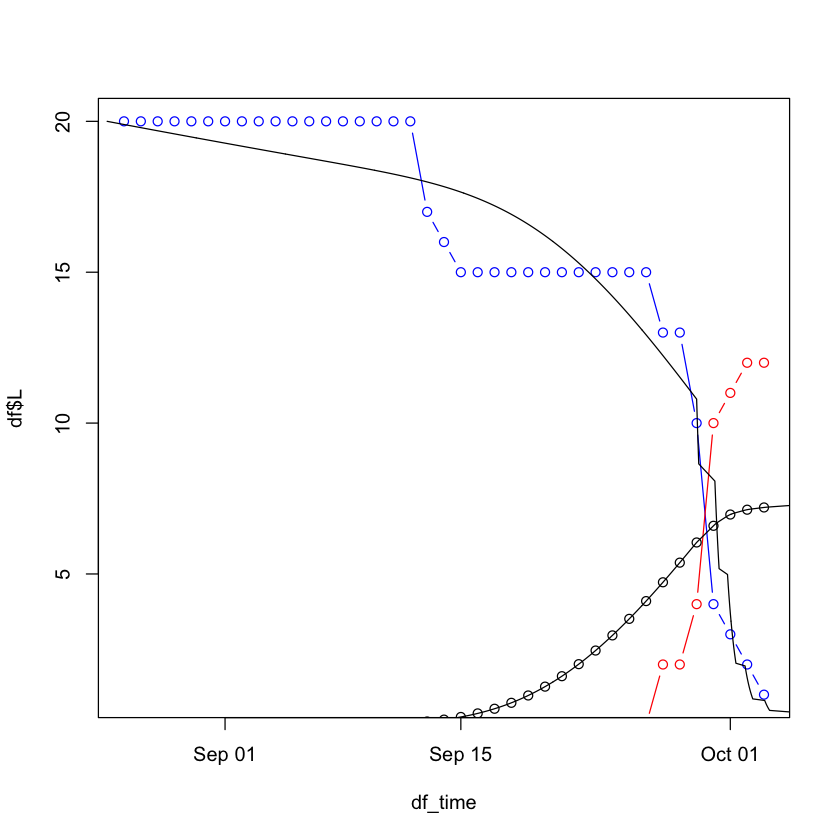

In [64]:
best_param <- fit$par
best_sim <- simulate_system(best_param)

plot(df_time,df$L,t='b',col='blue')
lines(df_time,df$P,t='b',col='red')

lines(tm_time, best_sim$larva, t='l')
lines(tm_time, best_sim$pupa, t='l')

best_sim_at_obs <- best_sim[tm_time %in% df_time, ]

lines(df_time, best_sim_at_obs$pupa, t='p')

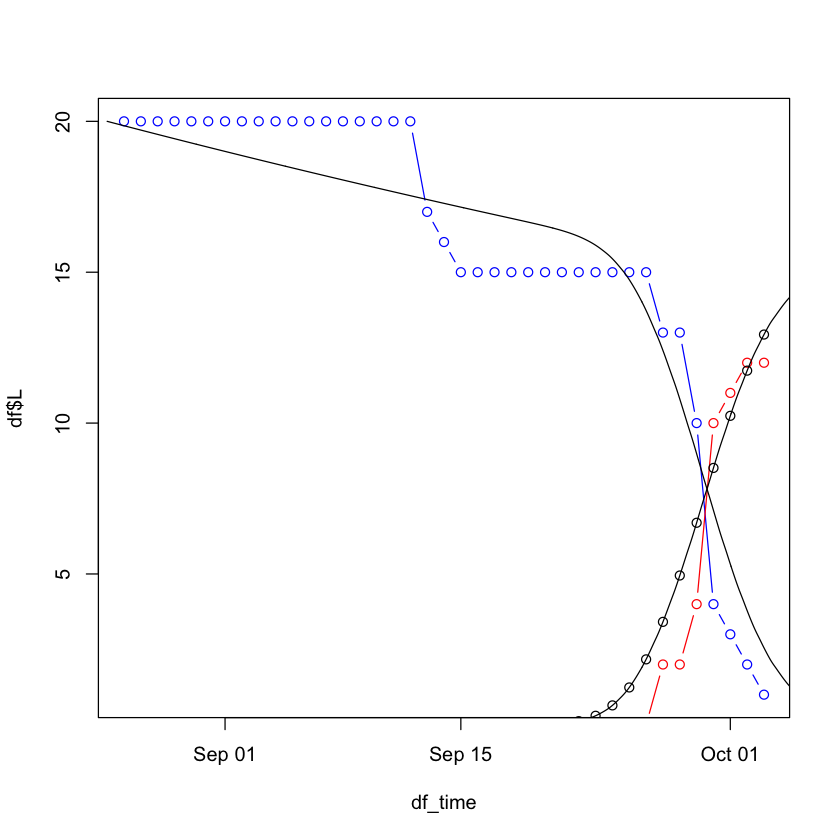

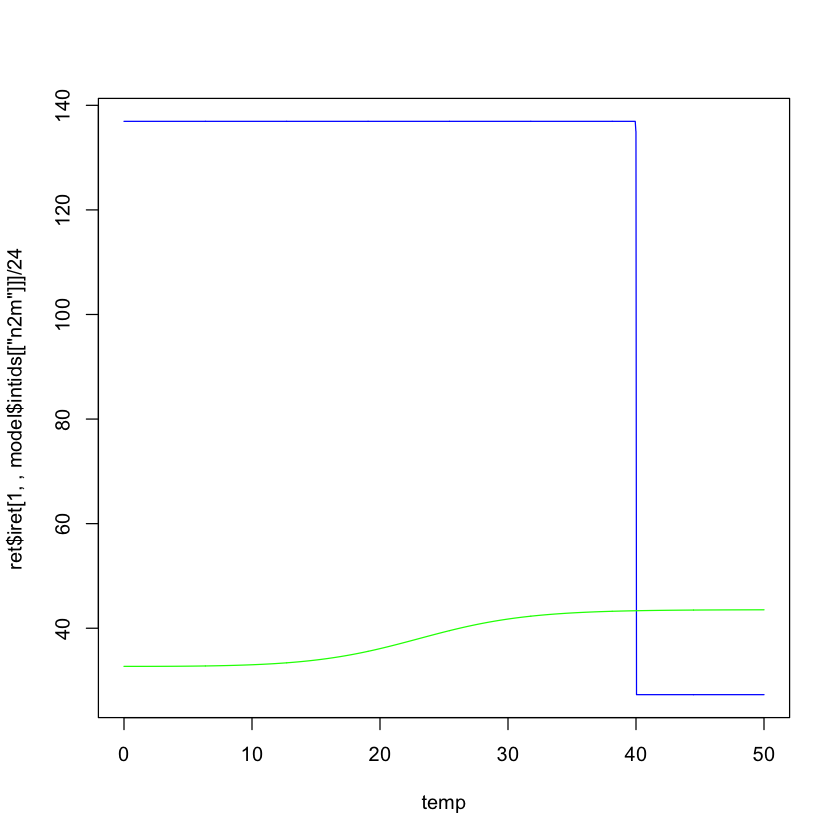

In [55]:
# This works when the standard deviation is 1% of the mean
best_param <- c(-10.0, 6.0, 50.0, 6.0, 655.094187, 2631.398751, 26.608980, -6.0, -3.672721, -1.440932, 540.172220, 1045.062222)

best_sim <- simulate_system(best_param)
best_sim_at_obs <- best_sim[tm_time %in% df_time, ]

plot(df_time,df$L,t='b',col='blue')
lines(df_time,df$P,t='b',col='red')
lines(tm_time, best_sim$larva, t='l')
lines(tm_time, best_sim$pupa, t='l')
lines(df_time, best_sim_at_obs$pupa, t='p')

temp <- seq(0,50,length.out=1000)

ret <- model$sim(
  ftime = length(temp)+1,
  envir = list(
    temp = temp
  ),
  pr = best_param,
  rep = -1
)

plot(temp, ret$iret[1, , model$intids[["n2m"]]] / 24.0, t='l', col='blue')
lines(temp, ret$iret[1, , model$intids[["d2m"]]] / 24.0, t='l', col='green')

I hope you found this tutorial informative for getting familiar with the PopJSON representation. You can now explore the *Aedes aegypti* model we have prepared for the CSVD Nicosia2025 Workshop using PopJSON.

In [4]:
model <- prepare("models/model_aegypti")

[1] "Reading model file: models/model_aegypti.json" 
[2] "Model translated to models/model_aegypti.c"    
[3] "Model file created: models/model_aegypti.dylib"


Loaded model with: 7 pops, 59 pars, 34 ints, 7 envs.



In [5]:
print(model$popnames)
print(model$parnames)
print(model$param)

[1] "pop_E"   "pop_Eh"  "pop_L"   "pop_P"   "pop_Afj" "pop_Af"  "pop_Afg"
 [1] "par_E_death_L"       "par_E_death_l"       "par_E_death_R"      
 [4] "par_E_death_r"       "par_E_death_X"       "par_E_death_str"    
 [7] "par_E_death_dsc"     "par_E_dev_R"         "par_E_dev_r"        
[10] "par_E_dev_min"       "par_E_dev_max"       "par_E_to_L"         
[13] "par_Eh_dev"          "par_Eh_bs_thr"       "par_Eh_T_thr"       
[16] "par_L_to_P"          "par_L_death_L"       "par_L_death_l"      
[19] "par_L_death_R"       "par_L_death_r"       "par_L_death_X"      
[22] "par_L_death_str"     "par_L_dev_min"       "par_L_dev_max"      
[25] "par_L_dev_a"         "par_L_fdens"         "par_L_fdens_str"    
[28] "par_L_fdens_mort"    "par_L_fdens_dev"     "par_P_death_L"      
[31] "par_P_death_l"       "par_P_death_R"       "par_P_death_r"      
[34] "par_P_death_X"       "par_P_death_str"     "par_P_dev_min"      
[37] "par_P_dev_max"       "par_P_dev_a"         "par_P_to_A"         
[40

But simulate using the [python](./tutorial_py.ipynb) wrapper instead! I think there is a bug in **population.R**. I am on it! 